# Predict receipt price with generated code

For the second try, I am using Chat GPT-3 to generate code that will create the model. 

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Load the data into a Pandas DataFrame
df = pd.read_csv("Receipts August 2022 - V6.csv")
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df['time of exit'] = pd.to_datetime(df['time of exit'], format='%H:%M:%S')

# Adding all the columns from third EDA
df['dow'] = df['date'].dt.day_of_week
df['is w'] = df['dow'] > 4
df['is nem'] = df['dow'].apply(lambda dow: 3 < dow < 6)
df['toe hour'] = df['time of exit'].dt.hour
df['toe minute'] = df['time of exit'].dt.minute
df['toe as n'] = df['toe hour'] + df['toe minute'] / 60
df = df.drop(columns=['id'])

# Removing the anomalies
df = df[df['toe as n'] > 15]
df = df[df['receipt price'] < 200]

I chose to predict `receipt price`. To predict this, I chose the highest numbers on the correlation matrix which are `toe as n` (0.31) and `is nem` (0.11). But `dow` will be used because it kind of includes `is nem`.

In [3]:
# Extract the relevant columns from the DataFrame
X = df[['toe as n', 'dow']]
y = df['receipt price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Train the linear regression model on the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model's performance on the testing data
print(model.score(X_test, y_test))

0.06079737023350518


The printed result has a lot of variation. I will modify this generated script by putting it in a for loop to get an average model score.

In [4]:
iterations = 1000
model_scores = []
models = []

for x in range(1, iterations + 1):
  # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    # Train the linear regression model on the training data
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Evaluate the model's performance on the testing data
    model_scores.append([x, model.score(X_test, y_test)])
    models.append(model)

average_model_score = np.average(model_scores, axis=0)[1]
print(f"average model score from {iterations} iterations:")
print(average_model_score)

average model score from 1000 iterations:
-0.006964530091449597


A negative score means that the model is useless. But I want to see the variation in the model scores so here are some plots and more information.

In [5]:
# model_scores.sort(key=lambda x:x[1])
npArr = np.array(model_scores)
x = npArr[:, 1]

In [6]:
dfX = pd.DataFrame()
dfX['x'] = x

dfX.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
x,1000.0,-0.006965,0.206808,-1.88144,-0.102899,0.03012,0.128699,0.467264


(array([  1.,   0.,   1.,   3.,   2.,  20.,  78., 316., 524.,  55.]),
 array([-1.88144004, -1.64656967, -1.4116993 , -1.17682893, -0.94195857,
        -0.7070882 , -0.47221783, -0.23734746, -0.00247709,  0.23239327,
         0.46726364]),
 <BarContainer object of 10 artists>)

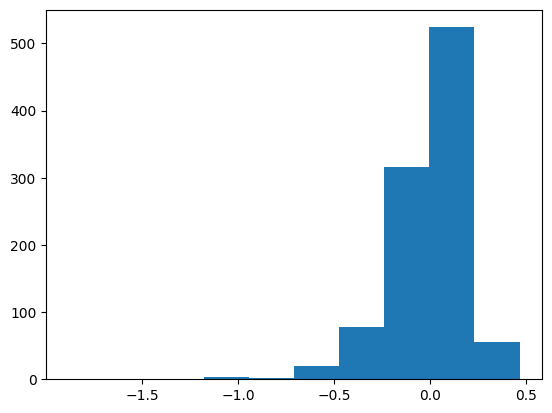

In [7]:
plt.hist(x)

<AxesSubplot: ylabel='Density'>

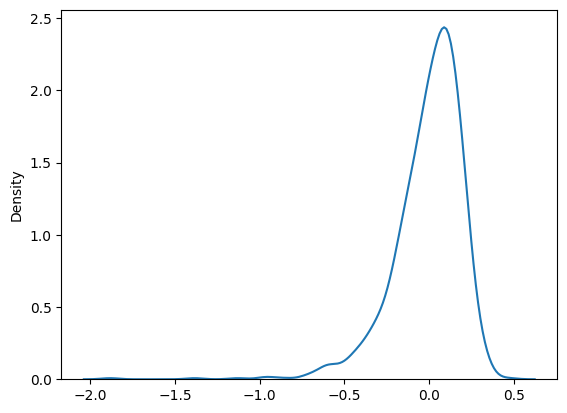

In [8]:
sns.kdeplot(x)

To force at least some sort of result, I will pick the strongest model.

In [9]:
highest_model_score = np.amax(x)
index = np.where(x == highest_model_score)[0][0]
strongest_model = models[index]

print(highest_model_score)

0.4672636426816491


In [10]:
# Use the strongest model to make predictions on new data
new_toe_as_n = 20.5
new_dow = 1 # (Tuesday)
new_data = [[new_toe_as_n, new_dow]]
result = model.predict(new_data)[0]
print(f"Predicted receipt price: €{result:.2f}")

Predicted receipt price: €67.81


c:\Users\Jussi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


To validate this result, it will be compared against a chart.

c:\Users\Jussi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


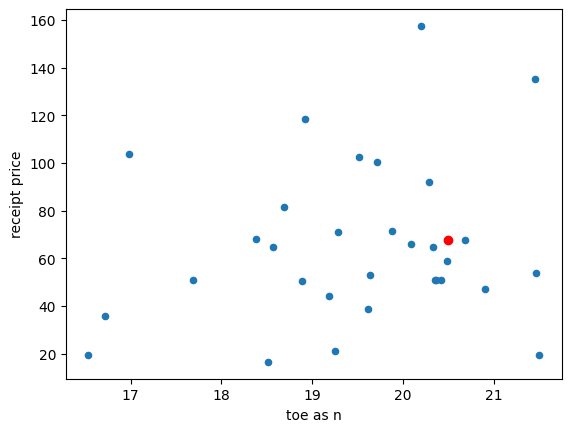

In [11]:
# Filtering the df for only Tuesday for a fair comparison
new_df = df[df['dow'] == 1]
new_df.plot.scatter(x='toe as n', y='receipt price')

plt.scatter(x=[new_toe_as_n], y=[result], c='red')

Lets add more red dots

In [17]:
predictions = []

for _new_toe_as_n in range(17, 22):
    predicted_receipt_price = model.predict([[_new_toe_as_n, new_dow]])[0]
    predictions.append([_new_toe_as_n, predicted_receipt_price])

predictions = np.array(predictions)

c:\Users\Jussi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Jussi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Jussi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Jussi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Jussi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but Line

c:\Users\Jussi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


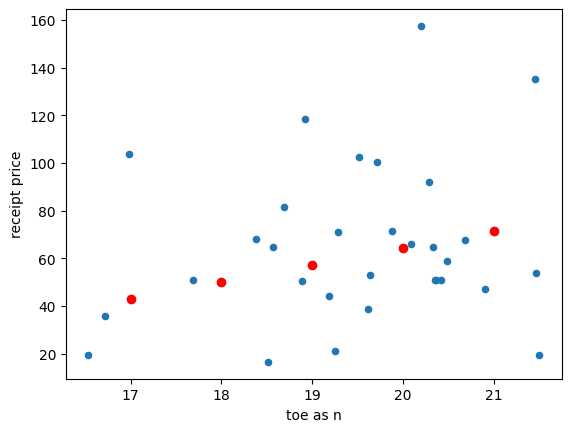

In [28]:
new_df.plot.scatter(x='toe as n', y='receipt price')

plt.scatter(x=predictions[:,0], y=predictions[:,1], c='red')

# Conclusion

The red dots follow the trend of the `receipt price` increasing as `toe as n` increases. This means that I have succesfully created a regression model using partly generated code by Chat GPT-3.